# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Loading required package: lme4
Loading required package: Matrix
Loading required package: Rcpp


Loading required package: lmerTest

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN


## Read in data files

In [5]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False

test_types = ['day2_noarrows_round2', 'day3_test1', 'day3_test2']
test_trials = ['training', 'test1', 'test2']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for env in proj['envs']:
            for test_type, test_trial in zip(test_types, test_trials):
    #             print env
                # add test file
                test_file = op.join(dirs['datadir'], 'nav', test_type, env, 
                                    subid, 'session_0', 'log.txt')
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)
                d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d2['subid'] = subid
                d2['env'] = env
                d2['test_trial'] = test_trial

                # force time to be integer, diff from end to beginning
                d2.time = d2.time.astype(int)
                d2.time = d2.time - d2.time.min()

                df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)


1
2
3
4


## Look at data

In [6]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,env,test_trial
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,env1,training
1,140,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,env1,training
2,140,0,VR_INIT,,,None,None,None,None,1,env1,training
3,140,0,VR_CREATED,,,None,None,None,None,1,env1,training
4,1946,0,CONF_LOAD,./config.py,None,,,None,None,1,env1,training


### Look at 2D position in space

In [7]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,terrain,"LPoint3f(0, 0, 0)",1,env1,training
1,6656,1,zebra,"LPoint3f(4, 34, 0.5)",1,env1,training
2,6656,1,lettuce,"LPoint3f(26, 52, 0.5)",1,env1,training
3,6656,1,George_Clooney,"LPoint3f(20, 22, 0.5)",1,env1,training
4,6656,1,zzz,"LPoint3f(12, 52, 0.2)",1,env1,training


In [8]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,env,test_trial,x,y,z
0,6656,terrain,1,env1,training,0,0,0.0
1,6656,zebra,1,env1,training,4,34,0.5
2,6656,lettuce,1,env1,training,26,52,0.5
3,6656,George_Clooney,1,env1,training,20,22,0.5
4,6656,zzz,1,env1,training,12,52,0.2


(<matplotlib.figure.Figure at 0x104524c90>,
 <matplotlib.axes.AxesSubplot at 0x10eaa8450>)

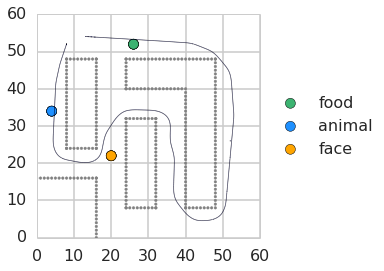

In [9]:
plot_paths(env='env1', subj='1', 
           dp=dp[dp.test_trial == 'training'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x12c3c62d0>,
 <matplotlib.axes.AxesSubplot at 0x12c3dd390>)

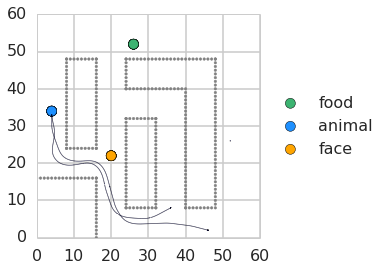

In [10]:
plot_paths(env='env1', subj='1', 
           dp=dp[dp.test_trial != 'training'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x1269f1f10>,
 <matplotlib.axes.AxesSubplot at 0x134704a90>)

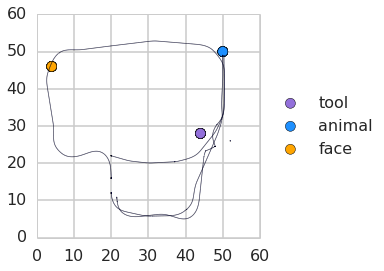

In [11]:
plot_paths(env='env3', subj='1', dp=dp, proj=proj)

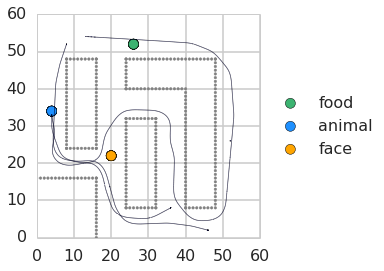

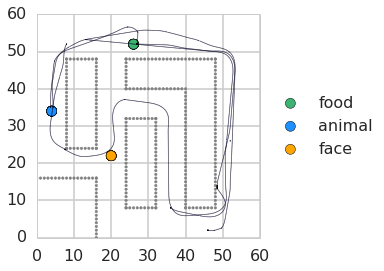

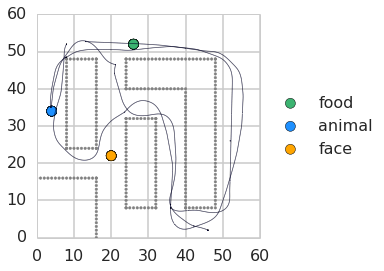

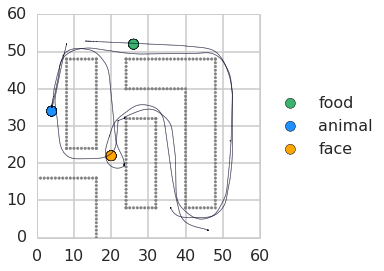

In [12]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_paths('env1', sub, dp, proj)

### Data for 1 subject, 1 environment

In [13]:
dsub = dp.query('env == "env1" & subid=="1" & c3=="PandaEPL_avatar"')
dsub.head()

,time,c3,subid,env,test_trial,x,y,z
5,6656,PandaEPL_avatar,1,env1,training,8,52,0.8
13,6656,PandaEPL_avatar,1,env1,training,8,52,0.8
15,6716,PandaEPL_avatar,1,env1,training,8,52,0.8
25,7086,PandaEPL_avatar,1,env1,training,8,52,0.8
27,7426,PandaEPL_avatar,1,env1,training,8,52,0.8


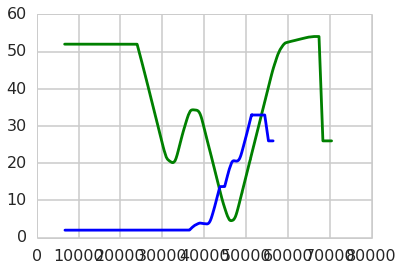

In [14]:
plt.plot(dsub[dsub.test_trial == 'training'].time, 
         dsub[dsub.test_trial == 'training'].y, 'green',
         dsub[dsub.test_trial == 'test1'].time, 
         dsub[dsub.test_trial == 'test1'].y, 'blue')

In [15]:
dsub.time.max()

70436

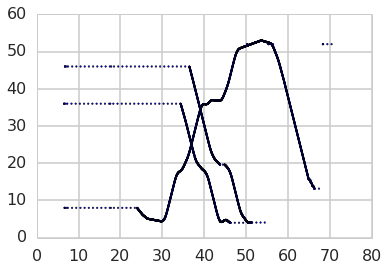

In [16]:
plt.scatter(dsub.time/1000, dsub.x.astype(float), 
            s=10, marker='.')

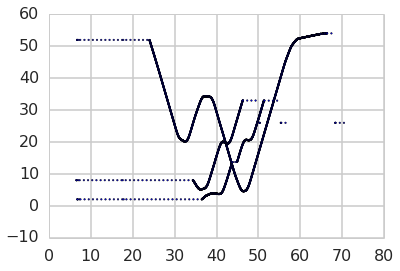

In [17]:
plt.scatter(dsub.time/1000, dsub.y.astype(float), 
            s=10, marker='.')

## Heading Direction

In [18]:
dh = df[(df.command == 'VROBJECT_HEADING') & (df.c3 == 'PandaEPL_avatar')].reset_index()
dh = dh.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dh.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,PandaEPL_avatar,90.0,1,env1,training
1,7986,21,PandaEPL_avatar,135.0,1,env1,training
2,9246,11,PandaEPL_avatar,180.0,1,env1,training
3,10506,11,PandaEPL_avatar,225.0,1,env1,training
4,11776,11,PandaEPL_avatar,270.0,1,env1,training


### Look at data just for 1 sub in 1 env

In [19]:
dsub = dh.query('env == "env3" & subid=="1"')
dsub.head()

,time,c2,c3,c4,subid,env,test_trial
8369,4173,1,PandaEPL_avatar,0.0,1,env3,training
8370,5503,21,PandaEPL_avatar,45.0,1,env3,training
8371,6753,21,PandaEPL_avatar,90.0,1,env3,training
8372,8003,21,PandaEPL_avatar,135.0,1,env3,training
8373,9273,11,PandaEPL_avatar,180.0,1,env3,training


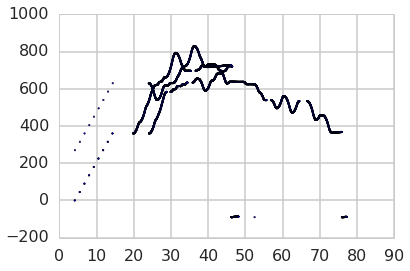

In [20]:
plt.scatter(dsub.time/1000, dsub.c4.astype(float), 
            s=10, marker='.')

## Text Events

In [21]:
dt = df[(df.command.isin(['ASSIGNED'])) 
        | df.command.isin(['ARRIVED'])].reset_index()
dt.ix[dt.command == 'ARRIVED', 'c3'] = 'between_trials'
dt = dt.drop(['c2', 'c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dt = dt.rename(columns={'c3': 'instructions'})
dt.head()

,time,instructions,subid,env,test_trial
0,17696,zzz,1,env1,training
1,66346,between_trials,1,env1,training
2,17778,zebra,1,env1,test1
3,51348,between_trials,1,env1,test1
4,17560,zebra,1,env1,test2


In [22]:
dt['total_time'] = (dt.time - dt.time.shift(1)).shift(-1)
dt.head()

,time,instructions,subid,env,test_trial,total_time
0,17696,zzz,1,env1,training,48650
1,66346,between_trials,1,env1,training,-48568
2,17778,zebra,1,env1,test1,33570
3,51348,between_trials,1,env1,test1,-33788
4,17560,zebra,1,env1,test2,28730


### Average time to navigate to goal

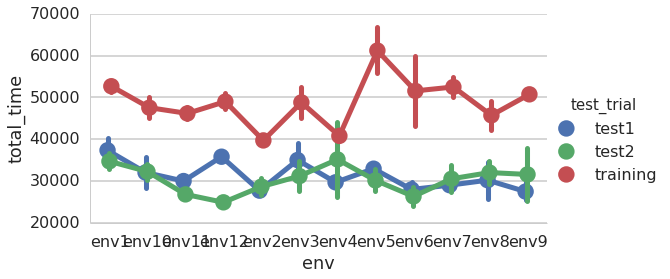

In [23]:
means = dt[dt.instructions != 'between_trials'].merge(subj_info).groupby(['subid', 'test_trial', 'env']).mean().reset_index()
sns.factorplot(x='env', y='total_time', aspect=2, hue='test_trial',
               units='subid', ci=68, dodge=.1,
               data=means)

## Input Events

In [24]:
di = df[(df.command == 'INPUT_EVENT')].reset_index()
di = di.drop(['c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
di = di.query('(c3 != "dismiss") & (c3 != "exit")')
di.head()

,time,c2,c3,subid,env,test_trial
0,22156,0,turnLeft,1,env1,training
1,22166,0,turnLeft,1,env1,training
2,22186,0,turnLeft,1,env1,training
3,22206,0,turnLeft,1,env1,training
4,22216,0,turnLeft,1,env1,training


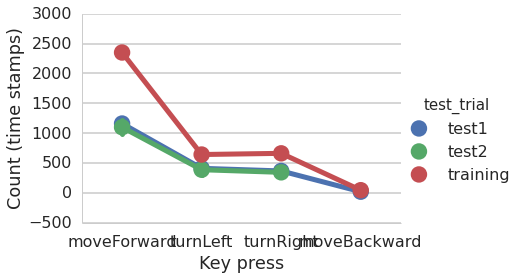

In [25]:
counts = di.merge(subj_info).groupby(['subid', 'test_trial', 'env', 'c3']).count().reset_index()

sns.factorplot(x='c3', y='time', aspect=1.5, hue='test_trial',
               units='subid', ci=68, data=counts)
plt.ylabel('Count (time stamps)')
plt.xlabel('Key press')

## Merge dataframes

In [26]:
dpt = dp.merge(dt, on=['subid', 'env', 'test_trial', 'time'], how='left')
dpt.ix[0,'instructions'] = 'intro'
dpt = dpt.fillna(method='ffill')
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [27]:
dpt.query('env == "env1" & c3 == "lettuce"')

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
2653,6736,lettuce,1,env1,test1,26,52,0.5,between_trials,-48568
3621,6518,lettuce,1,env1,test2,26,52,0.5,between_trials,-33788
58242,6906,lettuce,2,env1,training,26,52,0.5,between_trials,-27892
60987,6886,lettuce,2,env1,test1,26,52,0.5,between_trials,-54070
62928,6498,lettuce,2,env1,test2,26,52,0.5,between_trials,-46198
120499,6863,lettuce,3,env1,training,26,52,0.5,between_trials,-23884
123228,7272,lettuce,3,env1,test1,26,52,0.5,between_trials,-53661
124639,6684,lettuce,3,env1,test2,26,52,0.5,between_trials,-40838
184585,6971,lettuce,4,env1,training,26,52,0.5,between_trials,-24027


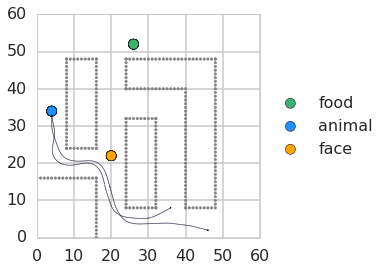

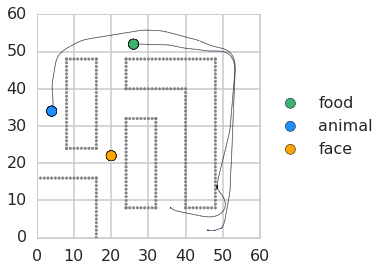

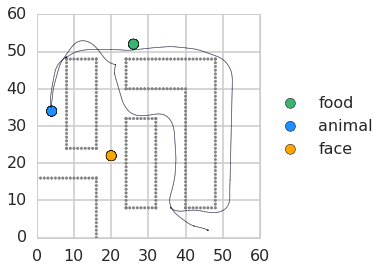

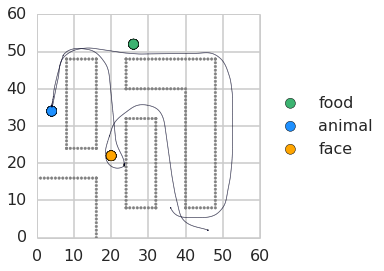

In [28]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_path('env1', sub, 'zebra', dpt, proj, dp)

(<matplotlib.figure.Figure at 0x134737c50>,
 <matplotlib.axes.AxesSubplot at 0x130ae1d50>)

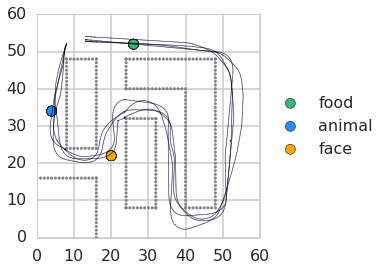

In [29]:
plot_paths_group('env1', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)

(<matplotlib.figure.Figure at 0x12e3fab10>,
 <matplotlib.axes.AxesSubplot at 0x130ae1910>)

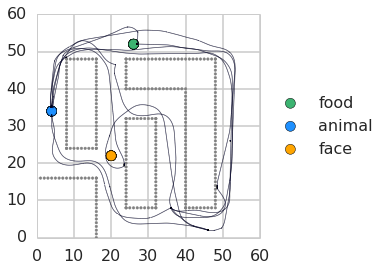

In [30]:
plot_paths_group('env1', subj_info.subid, 
                 dpt.query('test_trial != "training"'), proj, dp)

(<matplotlib.figure.Figure at 0x12a94f4d0>,
 <matplotlib.axes.AxesSubplot at 0x12e344650>)

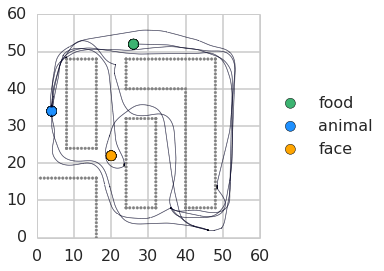

In [31]:
plot_path_group('env1', subj_info.subid, 'zebra', dpt, proj, dp)

(<matplotlib.figure.Figure at 0x12e2b3f50>,
 <matplotlib.axes.AxesSubplot at 0x12a86e590>)

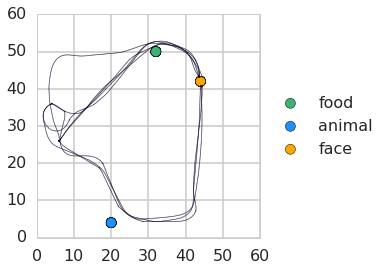

In [32]:
plot_path_group('env2', subj_info.subid, 'Mark_Zuckerberg', dpt, proj, dp)

In [33]:
dpt.query('env == "env3"').instructions.unique()

array(['between_trials', 'zzz', 'brown_bear'], dtype=object)

(<matplotlib.figure.Figure at 0x12eea9ed0>,
 <matplotlib.axes.AxesSubplot at 0x131632cd0>)

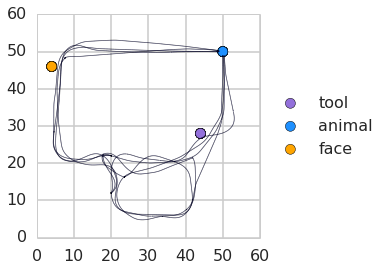

In [34]:
plot_path_group('env3', subj_info.subid, 'brown_bear', dpt, proj, dp)

In [35]:
dpt.query('env == "env4"').instructions.unique()

array(['between_trials', 'zzz', 'saw'], dtype=object)

(<matplotlib.figure.Figure at 0x12e2c9b90>,
 <matplotlib.axes.AxesSubplot at 0x12c94af10>)

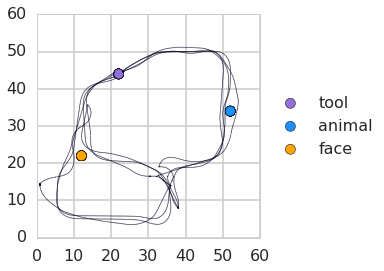

In [36]:
plot_path_group('env4', subj_info.subid, 'saw', dpt, proj, dp)

## Calculate Path Lengths

In [37]:
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [38]:
dplen = pd.DataFrame(columns=['subid', 'env', 'goal_type', 'path_len'])

for env in proj['envs']:
    goals = set(dpt[dpt.env == env].instructions)
    goals.discard('between_trials')
    goals.discard('intro')

    for subid in subj_info.subid:
#         print subid
        
        for goal in goals:
#             print goal

            goal_type = dict((v,k) for k,v in proj['goals'][env].items()).get(goal)
#             print goal_type
            data_sub = dpt[(dpt.subid == subid) & (dpt.env == env) & 
                           (dpt.instructions == goal) & 
                           (dpt.c3 == 'PandaEPL_avatar')]
            distance = sp.spatial.distance.euclidean(data_sub.x, data_sub.y)
            
            row = pd.Series({'subid': subid,
                             'env': env,
                             'goal_type': goal_type,
                             'path_len': distance})
            dplen = dplen.append(row, ignore_index=True)

In [39]:
dplen.head()

,subid,env,goal_type,path_len
0,1,env1,None,1259.605132
1,1,env1,animal,839.519945
2,2,env1,None,1231.693554
3,2,env1,animal,1530.083381
4,3,env1,None,1279.596593


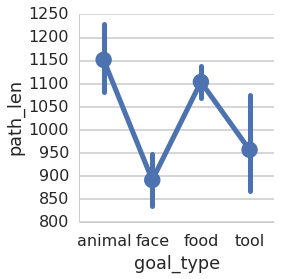

In [40]:
means = dplen.merge(subj_info).groupby(['subid', 'goal_type']).mean().reset_index()

sns.factorplot(x='goal_type', y='path_len', 
               units='subid', ci=68, dodge=.1,
               data=means)

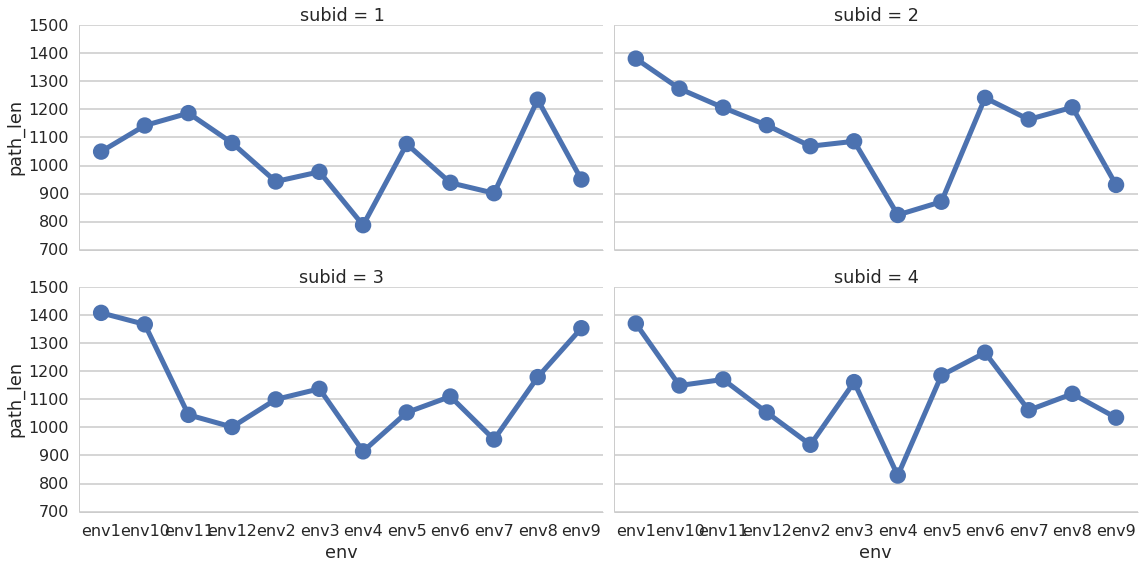

In [41]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               col='subid', col_wrap=2,
               dodge=.1,
               data=means)

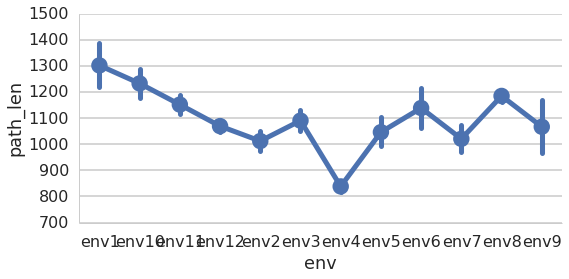

In [42]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               units='subid', ci=68, dodge=.1,
               data=means, )